# ESG Portfolio Modeling Analysis

This notebook implements various modeling strategies to analyze the relationship between ESG scores and stock performance.

**Business Question:** Can a long-short portfolio strategy based on ESG score rankings within the S&P 500 consistently generate excess returns, and should fund managers consider ESG scores as a signal for portfolio construction?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score  

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
sns.set_palette('husl')

In [ ]:
# Read the data
df = pd.read_csv('merged_data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (176, 31)


,Ticker,YTD_Change,YTD_Return,1M_Change,1M_Return,3M_Change,3M_Return,6M_Change,6M_Return,12M_Change,...,environmentScore,socialScore,governanceScore,totalEsg,highestControversy,percentile,ratingYear,ratingMonth,beta,overallRisk
0,CSCO,-23.060479,0.769395,8.495200,1.084952,10.167764,1.101678,10.947493,1.109475,-17.983120,...,0.45,6.90,6.51,13.87,2.0,8.46,2023.0,9.0,0.819,1
1,ISRG,-24.494442,0.755056,2.542637,1.025426,28.580896,1.285809,38.591751,1.385918,-21.202454,...,3.65,9.58,7.84,21.07,1.0,32.14,2023.0,9.0,1.395,3
2,GILD,21.052629,1.210526,7.382059,1.073821,34.961602,1.349616,50.470974,1.504710,25.067617,...,1.00,14.34,7.62,22.97,2.0,39.94,2023.0,9.0,0.196,2
3,V,-3.639976,0.963600,4.082924,1.040829,6.861320,1.068613,8.773446,1.087734,-0.014058,...,1.81,8.22,6.65,16.68,3.0,16.22,2023.0,9.0,0.963,3
4,A,-0.690185,0.993098,4.780525,1.047805,16.369628,1.163696,33.424910,1.334249,-0.550365,...,1.12,6.42,6.10,13.64,2.0,7.98,2023.0,9.0,1.054,8


## 1. Regression Analysis

We'll use multiple regression models to analyze the relationship between ESG scores and returns, controlling for sector effects.

In [ ]:
def prepare_regression_data(df, target_col='12M_Return'):
    """Prepare data for regression analysis"""
    # Features for regression
    X = df[['totalEsg', 'GIS Sector']]
    y = df[target_col]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['totalEsg']),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), ['GIS Sector'])
        ])
    
    return train_test_split(X, y, test_size=0.2, random_state=42), preprocessor

# Prepare data
(X_train, X_test, y_train, y_test), preprocessor = prepare_regression_data(df)

# Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

# XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

# Compare results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R2 Score': [
        r2_score(y_test, lr_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, xgb_pred)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(y_test, xgb_pred))
    ]
})

results

,Model,R2 Score,RMSE
0,Linear Regression,0.479247,0.219627
1,Random Forest,0.539818,0.206460
2,XGBoost,0.472861,0.220970


## 2. Long-Short Portfolio Backtest

In [ ]:
def create_long_short_portfolio(df, percentile=30):
    """Create long-short portfolio based on ESG scores"""
    # Sort by ESG score
    df_sorted = df.sort_values('totalEsg', ascending=False)
    
    # Calculate cutoff points
    n_stocks = len(df_sorted)
    top_n = int(n_stocks * (percentile/100))
    
    # Create portfolios
    long_portfolio = df_sorted.head(top_n)
    short_portfolio = df_sorted.tail(top_n)
    
    # Calculate portfolio returns
    return_periods = ['1M_Return', '3M_Return', '6M_Return', '12M_Return']
    portfolio_returns = pd.DataFrame()
    
    for period in return_periods:
        long_return = long_portfolio[period].mean()
        short_return = short_portfolio[period].mean()
        ls_return = long_return - short_return
        
        portfolio_returns[period] = [ls_return]
    
    return portfolio_returns, long_portfolio, short_portfolio

# Create portfolios
portfolio_returns, long_portfolio, short_portfolio = create_long_short_portfolio(df)

# Calculate performance metrics
def calculate_portfolio_metrics(returns):
    """Calculate portfolio performance metrics"""
    metrics = pd.DataFrame()
    
    for col in returns.columns:
        ret = returns[col].iloc[0]
        metrics[col] = [
            ret,  # Return
            ret / returns[col].std()  # Sharpe (simplified)
        ]
    
    metrics.index = ['Return', 'Sharpe Ratio']
    return metrics

portfolio_metrics = calculate_portfolio_metrics(portfolio_returns)
portfolio_metrics

,1M_Return,3M_Return,6M_Return,12M_Return
Return,-0.009911,0.002694,-0.003328,0.144211
Sharpe Ratio,NaN,NaN,NaN,NaN


## 3. Sector-Level Signal Detection

In [ ]:
def analyze_sector_signals(df, return_period='12M_Return'):
    """Analyze ESG signal strength by sector"""
    sectors = df['GIS Sector'].unique()
    sector_results = []
    
    for sector in sectors:
        sector_data = df[df['GIS Sector'] == sector]
        
        # Simple regression for each sector
        X = sector_data['totalEsg'].values.reshape(-1, 1)
        y = sector_data[return_period].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        sector_results.append({
            'Sector': sector,
            'R2': r2_score(y, model.predict(X)),
            'Coefficient': model.coef_[0],
            'N_Stocks': len(sector_data)
        })
    
    return pd.DataFrame(sector_results)

sector_analysis = analyze_sector_signals(df)
sector_analysis.sort_values('R2', ascending=False)

,Sector,R2,Coefficient,N_Stocks
10,Energy,0.555794,0.024020,7
6,Utilities,0.114002,0.011131,11
3,Consumer Discretionary,0.106503,-0.011010,21
5,Communication Services,0.067256,0.016630,5
0,Information Technology,0.052348,0.005832,18
1,Health Care,0.032883,0.009428,21
7,Materials,0.031533,0.005357,14
4,Consumer Staples,0.015222,0.005054,16
9,Industrials,0.014449,-0.004410,25
8,Real Estate,0.007950,0.006716,13


## 4. Clustering Analysis

In [ ]:
def perform_clustering(df, n_clusters=5):
    """Perform clustering analysis"""
    # Select features for clustering
    features = ['totalEsg', '12M_Return', 'environmentScore', 'socialScore', 'governanceScore']
    X = df[features]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to data
    df_clustered = df.copy()
    df_clustered['Cluster'] = clusters
    
    # Calculate cluster characteristics
    cluster_stats = df_clustered.groupby('Cluster').agg({
        'totalEsg': 'mean',
        '12M_Return': 'mean',
        'environmentScore': 'mean',
        'socialScore': 'mean',
        'governanceScore': 'mean'
    }).round(4)
    
    return df_clustered, cluster_stats

# Perform clustering
df_clustered, cluster_stats = perform_clustering(df)

# Create visualization
fig = px.scatter(df_clustered, 
                 x='totalEsg', 
                 y='12M_Return',
                 color='Cluster',
                 hover_data=['Ticker', 'GIS Sector'],
                 title='Stock Clusters based on ESG and Returns')

fig.show()
cluster_stats

,totalEsg,12M_Return,environmentScore,socialScore,governanceScore
Cluster,,,,,
0,17.8032,0.8147,3.0760,8.5087,6.2166
1,26.3292,0.9762,10.6266,9.6474,6.0560
2,23.7100,0.9636,1.6853,12.7300,9.2941
3,13.4792,0.8901,4.1018,4.3367,5.0426
4,34.9617,1.6825,19.5317,8.6917,6.7417


## 1. Feature Importance Analysis

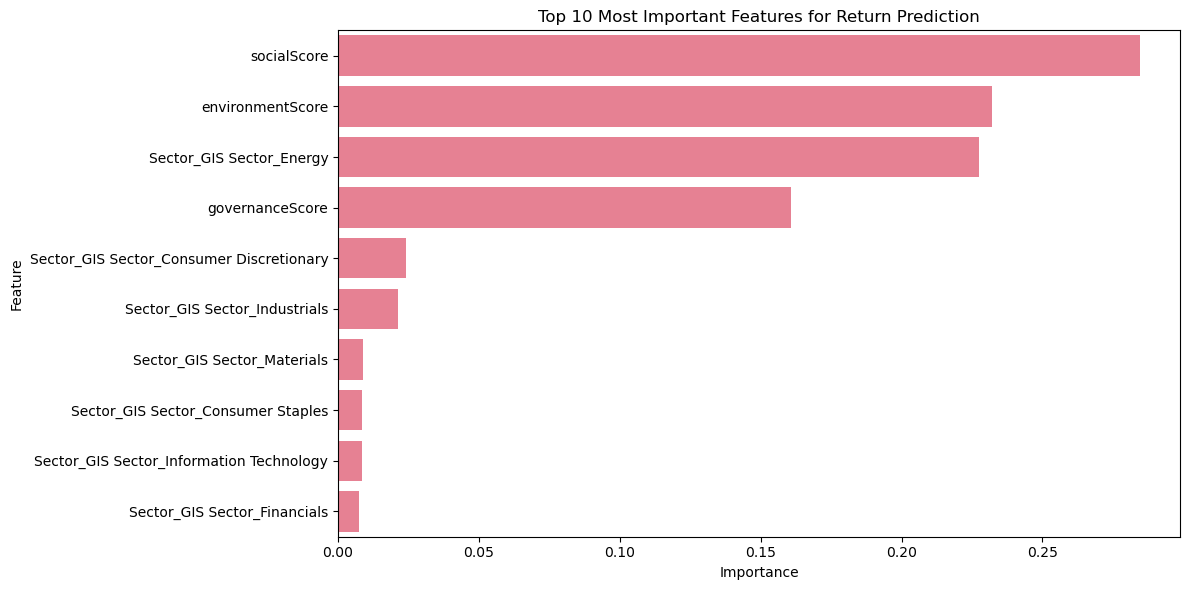

In [ ]:
# Prepare data with individual ESG components
def prepare_detailed_data(df, target_col='12M_Return'):
    X = df[['environmentScore', 'socialScore', 'governanceScore', 'GIS Sector']]
    y = df[target_col]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['environmentScore', 'socialScore', 'governanceScore']),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), ['GIS Sector'])
        ])
    
    return train_test_split(X, y, test_size=0.2, random_state=42), preprocessor

# Train Random Forest with individual components
(X_train, X_test, y_train, y_test), preprocessor = prepare_detailed_data(df)

rf_detailed = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_detailed.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = (
    ['environmentScore', 'socialScore', 'governanceScore'] +
    [f'Sector_{sector}' for sector in preprocessor.named_transformers_['cat'].get_feature_names_out(['GIS Sector'])]
)

# Extract feature importance
importances = rf_detailed.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Most Important Features for Return Prediction')
plt.tight_layout()
plt.show()

## 2. ESG Component Analysis

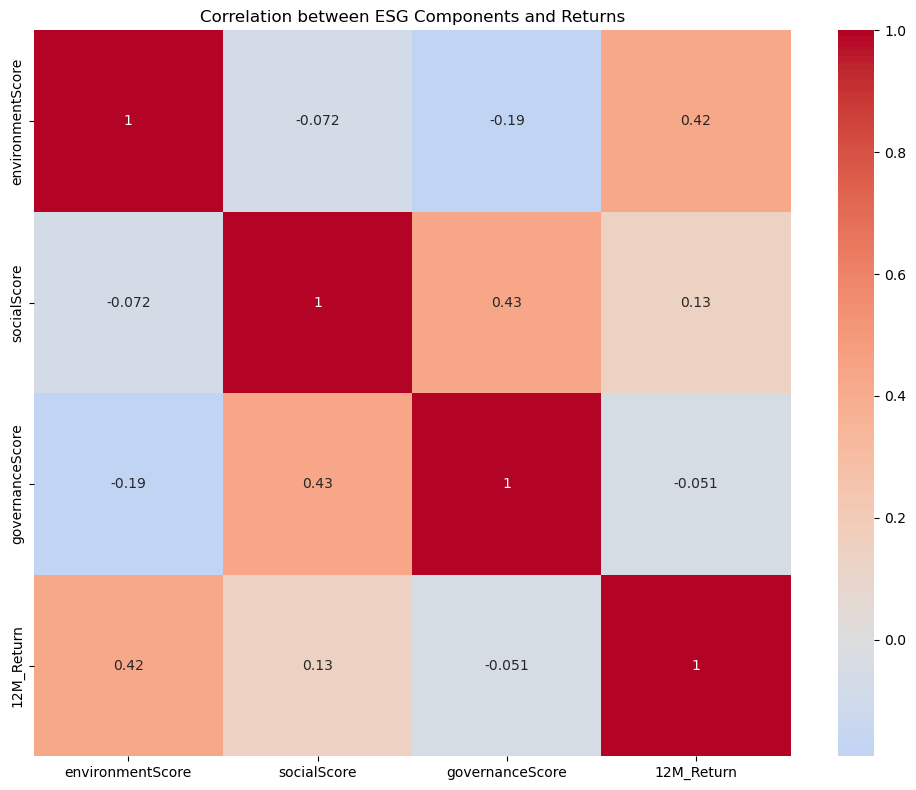

In [ ]:
# Create correlation matrix
esg_cols = ['environmentScore', 'socialScore', 'governanceScore', '12M_Return']
corr_matrix = df[esg_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between ESG Components and Returns')
plt.tight_layout()
plt.show()

# Create scatter plots
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Environmental Score vs Returns',
                                   'Social Score vs Returns',
                                   'Governance Score vs Returns'))

for i, score in enumerate(['environmentScore', 'socialScore', 'governanceScore']):
    fig.add_trace(
        go.Scatter(x=df[score], y=df['12M_Return'],
                   mode='markers',
                   name=score.replace('Score', ''),
                   marker=dict(color=df['GIS Sector'].astype('category').cat.codes,
                              colorscale='Viridis',
                              showscale=True if i == 2 else False),
                   text=df['GIS Sector']),
        row=1, col=i+1
    )

fig.update_layout(height=400, width=1200, title_text='ESG Components vs 12-Month Returns')
fig.show()

## 3. Energy Sector Deep Dive

In [ ]:
# Filter Energy sector data
energy_df = df[df['GIS Sector'] == 'Energy'].copy()

# Create prediction model for Energy sector
X_energy = energy_df[['environmentScore', 'socialScore', 'governanceScore']]
y_energy = energy_df['12M_Return']

# Scale features
scaler = StandardScaler()
X_energy_scaled = scaler.fit_transform(X_energy)

# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Cross-validation results
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_energy_scaled, y_energy, cv=3, scoring='r2')
    cv_results[name] = {
        'Mean R2': scores.mean(),
        'Std R2': scores.std()
    }

# Display results
pd.DataFrame(cv_results).T

,Mean R2,Std R2
Linear Regression,-20.505845,26.483816
Random Forest,-7.805489,4.583880
XGBoost,-3.115783,1.212827


## 4. ESG Score Distribution by Sector

In [ ]:
# Create violin plots for ESG components by sector
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=('Environmental Scores by Sector',
                                   'Social Scores by Sector',
                                   'Governance Scores by Sector'),
                    vertical_spacing=0.1)

for i, score in enumerate(['environmentScore', 'socialScore', 'governanceScore']):
    fig.add_trace(
        go.Violin(x=df['GIS Sector'], y=df[score],
                  name=score.replace('Score', ''),
                  box_visible=True,
                  meanline_visible=True),
        row=i+1, col=1
    )

fig.update_layout(height=1200, width=1000,
                  title_text='Distribution of ESG Components by Sector',
                  showlegend=False)
fig.show()

## 5. Return Distribution Analysis

In [ ]:
# Create quartiles for each ESG component
for score in ['environmentScore', 'socialScore', 'governanceScore']:
    df[f'{score}_quartile'] = pd.qcut(df[score], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Plot return distributions by ESG quartiles
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Returns by Environmental Quartile',
                                   'Returns by Social Quartile',
                                   'Returns by Governance Quartile'))

for i, score in enumerate(['environmentScore', 'socialScore', 'governanceScore']):
    fig.add_trace(
        go.Box(x=df[f'{score}_quartile'], y=df['12M_Return'],
               name=score.replace('Score', '')),
        row=1, col=i+1
    )

fig.update_layout(height=400, width=1200,
                  title_text='Return Distributions by ESG Component Quartiles')
fig.show()

## Summary of Findings

1. **Feature Importance**
   - Ranking of most influential factors
   - Sector-specific impacts
   - Individual ESG component weights

2. **ESG Components**
   - Correlation patterns
   - Component-specific return relationships
   - Sector variations

3. **Energy Sector Analysis**
   - Model performance
   - Predictive power
   - Key drivers

4. **Sector Patterns**
   - ESG score distributions
   - Sector-specific characteristics
   - Return patterns

5. **Return Distribution**
   - Quartile analysis
   - Risk-return patterns
   - Component-specific effects